# Baseline - Patching comparison

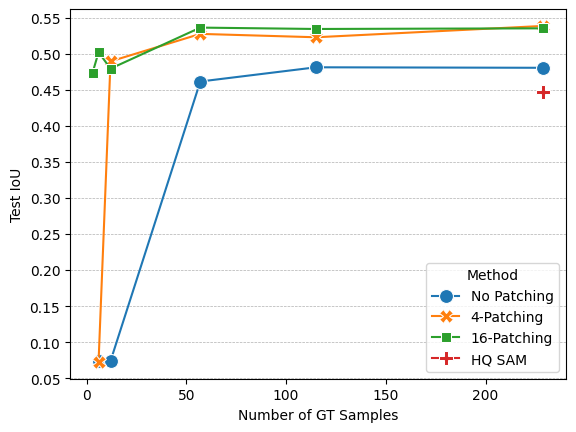

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csv_df = pd.read_csv("wb_export_baseline.csv")
csv_df = csv_df[[col for col in csv_df.columns if col.endswith("test_IoU")]]


data = []
for col in csv_df.columns:
    method = (
        "4-Patching"
        if "patched4" in col
        else "16-Patching" if "patched16" in col else "No Patching"
    )
    n_samples = col.replace("_samples_aug - test_IoU", "").split("_")[-1]
    n_samples = int(n_samples) if n_samples != "all" else 229
    if n_samples == 1:
        continue

    test_IoU = csv_df[col].dropna().item()

    data.append(
        {"Method": method, "Number of GT Samples": n_samples, "Test IoU": test_IoU}
    )

data.append({"Method": "HQ SAM", "Number of GT Samples": 229, "Test IoU": 0.4467})
df = pd.DataFrame(data)
# plot line chart with one line per method and n_samples on x axis
import seaborn as sns

sns.lineplot(
    data=df,
    x="Number of GT Samples",
    y="Test IoU",
    hue="Method",
    markers=True,
    style="Method",
    dashes=False,
    markersize=10,
)
plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))

# Baseline - Offline ST comparison

## Create Dataframe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

default_df = pd.read_csv("wb_export_offlineST_vs_baseline.csv")
default_df = default_df[[col for col in default_df.columns if col.endswith("test_IoU")]]

optimal_threshold_df = pd.read_csv(
    "wb_export_offlineST_vs_baseline_optimalThreshold.csv"
)
optimal_threshold_df = optimal_threshold_df[
    [
        col
        for col in optimal_threshold_df.columns
        if col.endswith("test_optimal_iou_threshold_IoU")
    ]
]

rows = []
for df in [default_df, optimal_threshold_df]:
    for col in df.columns:
        method = "Baseline" if "gt_vessels_patched4_baseline_" in col else "OfflineST"
        is_optimal_threshold = col.endswith("test_optimal_iou_threshold_IoU")
        method_additions = []
        is_baseline = "gt_vessels_patched4_baseline_" in col
        mixed_labels = "mixedLabels" in col
        frozen_img_enc = "frozenImgEnc" in col
        confidence = "confidence" in col
        if mixed_labels:
            method_additions.append("Mixed Labels")
        if frozen_img_enc:
            method_additions.append("Frozen Image Encoder during ST")
        if confidence:
            method_additions.append("Confidence")
        if is_optimal_threshold:
            method_additions.append("Optimal Threshold")

        if len(method_additions) > 0:
            method += f" ({', '.join(method_additions)})"
        n_samples = (
            col.replace("gt_vessels_patched4_baseline_", "")
            .replace("vessels_gt_patched4_OfflineST_fft_", "")
            .split("_")[0]
        )
        n_samples = int(n_samples) if n_samples != "all" else 229
        rows.append(
            {
                "Method": method,
                "Number of Ground Truth Training Samples": n_samples,
                "Test IoU": df[col].dropna().item(),
                "Optimal Threshold": is_optimal_threshold,
                "Mixed Labels": mixed_labels,
                "Frozen Image Encoder during ST": frozen_img_enc,
                "Confidence": confidence,
                "Method Id": confidence
                + 2 * mixed_labels
                + 4 * frozen_img_enc
                + 8 * (not is_baseline),
            }
        )
df = pd.DataFrame(rows)

# Assign colors to each unique method Id
unique_method_ids = df["Method Id"].unique()
# Use a color palette suitable for color blind people
color_palette = sns.color_palette("colorblind", len(unique_method_ids))

color_map = {
    method_id: color_palette[i] for i, method_id in enumerate(unique_method_ids)
}
df["Color"] = df["Method Id"].map(color_map)

# Set Alpha column based on Optimal Threshold
df["Alpha"] = df["Optimal Threshold"].apply(lambda x: 1.0 if x else 0.7)

df["Color"].dtype
df

# Performance progression comparisson vs. Baseline

In [ ]:
# plot line chart with one line per method and n_samples on x axis, with the same color for the same method
import seaborn as sns

# Create the plot
plt.figure(figsize=(9, 7))
df = df[df["Confidence"] == False]
df = df[df["Method Id"] != 12]
methods = df.sort_values(by=["Method Id", "Optimal Threshold"])["Method"].unique()
# Plot each method separately
for method in methods:
    subset_df = df[df["Method"] == method]
    dashed = not bool(subset_df["Optimal Threshold"].iloc[0])
    sns.lineplot(
        data=subset_df,
        x="Number of Ground Truth Training Samples",
        y="Test IoU",
        color=subset_df["Color"].iloc[0],
        alpha=subset_df["Alpha"].mean(),
        label=method,
        markers=True,
        dashes=(2, 2) if dashed else False,
        markersize=4,
        marker="o",
    )

plt.legend(
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    ncol=3,
    fontsize="small",
)
plt.grid(axis="both", which="both", linestyle="--", linewidth=0.5)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.025))
plt.tight_layout()

# Comparison for specific GT subset (small)

In [ ]:
import matplotlib.pyplot as plt

df6 = df[df["Number of Ground Truth Training Samples"] == 6]
method_ids = df.sort_values(by=["Method Id", "Optimal Threshold"])["Method Id"].unique()
# Plot bar chart with logarithmic y axis
plt.figure(figsize=(1, 6))

for i, method in enumerate(method_ids):
    subset_df = df6[df6["Method Id"] == method]
    # subset_df contains both thresholded and unthresholded results

    for _, row in subset_df.iterrows():
        edgecolor = "white" if not row["Optimal Threshold"] else None
        linestyle = (0, (1, 1)) if not row["Optimal Threshold"] else None
        plt.bar(
            i,
            row["Test IoU"],
            color=row["Color"],
            alpha=row["Alpha"],
            edgecolor=edgecolor,
            linestyle=linestyle,
            linewidth=2,
            zorder=(
                1 if row["Optimal Threshold"] else 2
            ),  # Ensure thresholded bars are drawn on top
            hatch="\\" if not row["Optimal Threshold"] else None,
        )
plt.yscale("log")
plt.ylabel("Test IoU")
plt.title("6 Ground Truth Training Samples", loc="right", fontsize="small")
# plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)
# plt.tight_layout()
plt.show()

# Comparison for specific GT subset (large with confidence)

In [ ]:
import matplotlib.pyplot as plt

df6 = df[df["Number of Ground Truth Training Samples"] == 6]
method_ids = df6.sort_values(by=["Method Id", "Optimal Threshold"])[
    "Method Id"
].unique()
# Plot bar chart with logarithmic y axis
plt.figure(figsize=(5, 6))
method_short_labels = ["Baseline", "OfflineST 1", "OfflineST 2", "OfflineST3"]
for i, method in enumerate(method_ids):
    subset_df = df6[df6["Method Id"] == method]
    # subset_df contains both thresholded and unthresholded results
    for _, row in subset_df.iterrows():
        edgecolor = "white" if not row["Optimal Threshold"] else None
        linestyle = (0, (1, 1)) if not row["Optimal Threshold"] else None
        plt.bar(
            method_short_labels[i],
            row["Test IoU"],
            color=row["Color"],
            edgecolor=edgecolor,
            label=row["Method"],
            linestyle=linestyle,
            linewidth=2,
            zorder=(
                1 if row["Optimal Threshold"] else 2
            ),  # Ensure thresholded bars are drawn on top
            hatch="\\" if not row["Optimal Threshold"] else None,
        )
plt.yscale("log")
plt.ylabel("Test IoU")
plt.title("6 Ground Truth Training Samples", loc="center", fontsize="small")
plt.legend(
    title="Method",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.3),
    ncol=2,
    fontsize="small",
)
# plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)
# plt.tight_layout()
plt.show()
df6